In [16]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error,r2_score

In [152]:
ticker = 'SPY'
df = yf.download(ticker, start='2010-01-01', end='2025-05-10')
df = df[['Close']].dropna()              # נשמור רק את עמודת הסגירה
df.rename(columns={'Close': 'Price'}, inplace=True)

[*********************100%***********************]  1 of 1 completed

1 Failed download:
['SPY']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


In [176]:
return_data = pd.read_pickle('df_with_QQQ.pkl')
return_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2071 entries, 0 to 2070
Data columns (total 47 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   QQQ_Close        2071 non-null   float64       
 1   ^RUT             2071 non-null   float64       
 2   ^VIX             2071 non-null   float64       
 3   EMA_20           2071 non-null   float64       
 4   ^GDAXI           2071 non-null   float64       
 5   MSFT             2071 non-null   float64       
 6   stdev_5          2071 non-null   float64       
 7   ^FTSE            2071 non-null   float64       
 8   GOOG             2071 non-null   float64       
 9   AAPL             2071 non-null   float64       
 10  high-low         2071 non-null   float64       
 11  avgreturn5d      2071 non-null   float64       
 12  abs_yield_curve  2071 non-null   float64       
 13  std_price        2071 non-null   float64       
 14  UNG              2071 non-null   float64

In [167]:
spy_only = pd.read_pickle('combined_cleaned_add.pkl')
spy_only.info()
#spy_only = spy_only[ 'SPY_Close']

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   SPY_Close            2084 non-null   float64
 1   SPY_Volume           2084 non-null   int64  
 2   AAPL                 2084 non-null   float64
 3   MSFT                 2084 non-null   float64
 4   GOOG                 2084 non-null   float64
 5   GLD                  2084 non-null   float64
 6   SLV                  2084 non-null   float64
 7   ^TNX                 2084 non-null   float64
 8   DX-Y.NYB             2084 non-null   float64
 9   JPY=X                2084 non-null   float64
 10  EUR=X                2084 non-null   float64
 11  USO                  2084 non-null   float64
 12  UNG                  2084 non-null   float64
 13  BTC-USD              2084 non-null   float64
 14  CPER                 2084 non-null   float64
 15  ^VIX                

In [25]:
spy_only = spy_only.to_frame()
spy_only.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2084 entries, 2017-01-03 to 2025-04-16
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SPY_Close  2084 non-null   float64
dtypes: float64(1)
memory usage: 97.1 KB


# Return data:


In [140]:
spy_only = spy_only.iloc[:,:2]

In [168]:
X = spy_only.drop(columns=['SPY_Close'])
y = spy_only['SPY_Close']

In [156]:
x1 = return_data.drop(columns=['SPY_return','ds'])
y1 = return_data['SPY_return']
scale1 = MinMaxScaler()
X_scaled1 = scale1.fit_transform(x1)
y_scaled1 = scale1.fit_transform(y1.values.reshape(-1, 1))

In [169]:
scale = MinMaxScaler()
X_scaled = scale.fit_transform(X)
y_scaled = scale.fit_transform(y.values.reshape(-1, 1))

In [158]:
split = int(0.8 * len(X))
X_train, X_test = X_scaled1[:split], X_scaled1[split:]
y_train, y_test = y_scaled1[:split], y_scaled1[split:]


# Normilize

In [163]:
#features = ['Price', 'Rolling Mean 5', 'Rolling Mean 30', 'Rolling Std 5', 'Rolling Std 30']
scaler = MinMaxScaler()
#arr = spy_only.values.reshape(-1, 1) 

scaled_data = scaler.fit_transform(spy_only)
#scaled_data = scaler.fit_transform(spy_only['SPY_Close'].values.reshape(-1, 1))
print(f"The model will get {scaled_data.shape[1]} features for each timestep")

The model will get 2 features for each timestep


In [142]:
print(scaled_data)

[[0.00522946 0.28530908]
 [0.00853653 0.28483443]
 [0.00808859 0.28669964]
 ...
 [0.81105019 0.43028967]
 [0.80865937 0.34799349]
 [0.77770533 0.3814774 ]]


# Creat sequence

In [170]:
def create_sequences_multifeature(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i, 0])  # תחזית רק למחיר
    return np.array(X), np.array(y)

window_size = 1
X, y = create_sequences_multifeature(scaled_data, window_size)

In [89]:
print(y)

[0.00806297 0.00970632 0.00845717 ... 0.81105019 0.80865937 0.77770533]


In [171]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]
print(X.shape[2])

2


In [133]:
print(X_train)

[[[5.22945563e-03 2.85309084e-01 1.29646954e-04 ... 0.00000000e+00
   7.78583410e-01 7.22996087e-01]
  [8.53653232e-03 2.84834430e-01 0.00000000e+00 ... 1.00000000e+00
   7.91861610e-01 7.34661905e-01]
  [8.08858966e-03 2.86699639e-01 5.88416060e-04 ... 1.00000000e+00
   7.89550820e-01 7.32973385e-01]
  [1.01312032e-02 2.35662714e-01 1.88490205e-03 ... 1.00000000e+00
   7.97262628e-01 7.40025159e-01]
  [8.06296794e-03 2.21567076e-01 2.96195133e-03 ... 1.00000000e+00
   7.88283106e-01 7.32614042e-01]]

 [[8.53653232e-03 2.84834430e-01 0.00000000e+00 ... 1.00000000e+00
   7.91861610e-01 7.34661905e-01]
  [8.08858966e-03 2.86699639e-01 5.88416060e-04 ... 1.00000000e+00
   7.89550820e-01 7.32973385e-01]
  [1.01312032e-02 2.35662714e-01 1.88490205e-03 ... 1.00000000e+00
   7.97262628e-01 7.40025159e-01]
  [8.06296794e-03 2.21567076e-01 2.96195133e-03 ... 1.00000000e+00
   7.88283106e-01 7.32614042e-01]
  [8.06296794e-03 2.70049850e-01 3.08161342e-03 ... 1.00000000e+00
   7.87902726e-01 7.32

# LSTM model

In [145]:
model_lstm = Sequential([
    LSTM(128, return_sequences=True, input_shape=(window_size, X.shape[2])),
    LSTM(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=False),
    Dense(10, activation='relu'),
    Dense(1)
])
model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# GRU model:

In [64]:
model_gru = Sequential([
    GRU(50, return_sequences=True, input_shape=(window_size, X.shape[2])),
    GRU(44),
    Dense(32, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [173]:
model_gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(window_size, X.shape[2])),
    GRU(128, return_sequences=True),
    GRU(98, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(10, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=40, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [174]:
pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scaler.min_[0], scaler.scale_[0]
pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [35]:
dates = spy_only.index[window_size + split:]

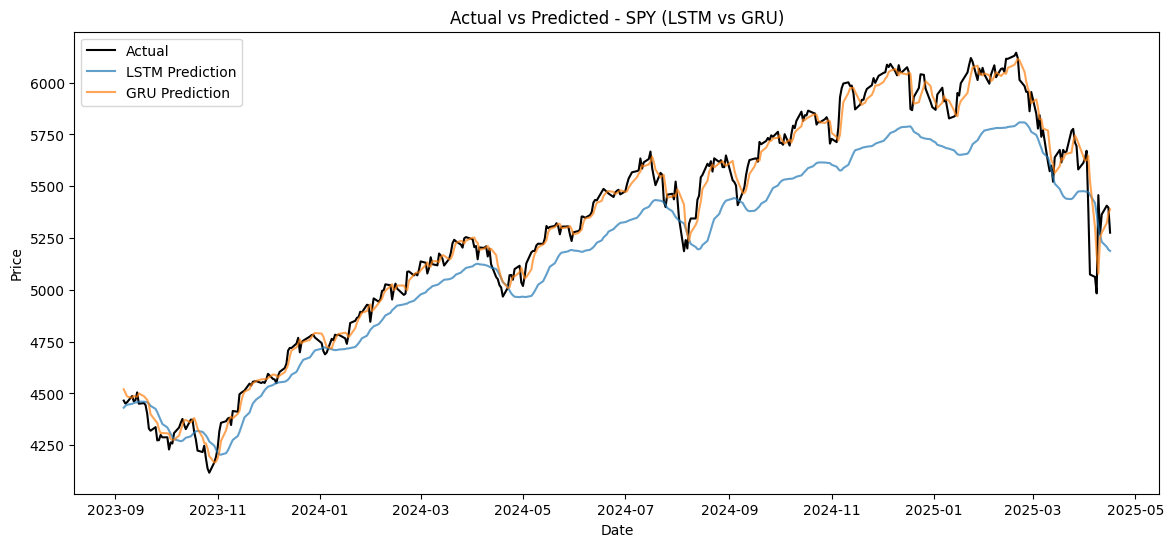

In [36]:
plt.figure(figsize=(14,6))
plt.plot(dates, y_test_actual, label='Actual', color='black')
plt.plot(dates, pred_lstm, label='LSTM Prediction', alpha=0.7)
plt.plot(dates, pred_gru, label='GRU Prediction', alpha=0.7)
plt.title(f'Actual vs Predicted - {ticker} (LSTM vs GRU)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(False)
plt.show()

In [175]:
mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 8808723.0540, R²: -26.9813
GRU  - MSE: 12934.3399, R²: 0.9589


# put spt_return as index number 1

In [186]:
return_data = return_data.reindex(columns=["SPY_return"] + list(return_data.columns.drop("SPY_return")))

In [ ]:
n = return_data.columns.to_list()
print(f"Features used in the model: {n}")


Features used in the model: ['SPY_return', 'QQQ_Close', '^RUT', '^VIX', 'EMA_20', '^GDAXI', 'MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d', 'abs_yield_curve', 'std_price', 'UNG', 'abs_vix', 'SLV', 'stdev', 'BTC-USD', 'EMA_50', 'EMA_200', '^TNX', 'USO', 'IWM_avg5d', 'shiler pe', 'JPY=X', 'GLD', 'SPY_AbsChange', 'SPY_Volume', '^N225', 'CPER', 'CNYUSD=X', 'before_high-low', 'abs_vol', 'IWM_std_5d', 'yield_curve', 'IEI', 'DX-Y.NYB', 'EUR=X', 'avgreturn10d', '2Y_Yield', 'EUR', 'SPY_RSI', 'DXY', 'JPY', 'ds']


# Return data

In [227]:
#x1 = return_data.drop(columns=['SPY_return','ds'])
#y1 = return_data['SPY_return']
cols = ['SPY_return', 'QQQ_Close', '^RUT', 'abs_vix','MSFT', 'stdev_5', '^FTSE', 'GOOG', 'AAPL', 'high-low', 'avgreturn5d']#, 'abs_yield_curve', 'std_price','abs_vix','SPY_AbsChange','abs_vol','2Y_Yield','EUR', 'SPY_RSI', 'DXY', 'JPY' ]
scale1 = MinMaxScaler()
return_data_cleaned = return_data.drop(columns=['ds'])
return_data_cleaned = return_data_cleaned[cols]
return_data_scaled = scale1.fit_transform(return_data_cleaned)

In [228]:
return_data_cleaned.head()

,SPY_return,QQQ_Close,^RUT,abs_vix,MSFT,stdev_5,^FTSE,GOOG,AAPL,high-low,avgreturn5d
0,-0.269012,-0.043024,-0.296631,11.77,0.350635,0.316581,-0.655697,1.775112,0.066658,14.760010,-0.082739
1,0.656459,0.864767,1.585499,11.07,0.889458,0.424201,-0.012591,0.556575,-0.091620,17.949951,0.107903
2,0.802609,0.988757,0.966249,10.81,0.251904,0.528980,0.197196,1.432266,1.592078,10.670166,0.233150
3,-0.073538,-0.020502,-0.494775,10.63,0.926479,0.459317,-0.040477,-0.421220,0.049234,6.909912,0.290628
4,-0.086646,0.099017,-0.356210,10.58,2.349481,0.486897,0.321162,-1.062304,0.008170,7.399902,0.205974


In [229]:
window = 5
x1, y1 = create_sequences_multifeature(return_data_scaled, window)

In [230]:
split = int(0.8 * len(x1))
X_train, X_test = x1[:split], x1[split:]
y_train, y_test = y1[:split], y1[split:]
print(x1.shape[2])

11


In [231]:
model_gru = Sequential([
    GRU(256, return_sequences=True, input_shape=(window, x1.shape[2])),
    GRU(128, return_sequences=True),
    GRU(98, return_sequences=True),
    GRU(64, return_sequences=True),
    GRU(32, return_sequences=False),
    Dense(10, activation='relu'),
    Dense(1)
])
model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

c:\Users\OMER\PycharmProjects\Project\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [232]:
#pred_lstm = model_lstm.predict(X_test)
pred_gru = model_gru.predict(X_test)

# reset the scaler to the original price range
price_scaler = MinMaxScaler()
price_scaler.min_, price_scaler.scale_ = scale1.min_[0], scale1.scale_[0]
#pred_lstm = price_scaler.inverse_transform(pred_lstm)
pred_gru = price_scaler.inverse_transform(pred_gru)
y_test_actual = price_scaler.inverse_transform(y_test.reshape(-1, 1))

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


In [233]:
#mse_lstm = mean_squared_error(y_test_actual, pred_lstm)
mse_gru = mean_squared_error(y_test_actual, pred_gru)

#r2_lstm = r2_score(y_test_actual, pred_lstm)
r2_gru = r2_score(y_test_actual, pred_gru)

print(f'LSTM - MSE: {mse_lstm:.4f}, R²: {r2_lstm:.4f}')
print(f'GRU  - MSE: {mse_gru:.4f}, R²: {r2_gru:.4f}')

LSTM - MSE: 8808723.0540, R²: -26.9813
GRU  - MSE: 1.1427, R²: -0.0474
